### 尝试训练2 ：Age & Gender classification task
-  选择mobilenet_v3进行进一步调试
- 其中删除对于性别的预测
- 同时使用五折交叉验证

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [22]:
import shutil
# 把olddir拷贝一份newdir
shutil.copytree('/content/MyDrive/MyDrive/aligned', 'aligned')

'aligned'

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import sys
import time
from pathlib import Path
import json
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

# fix random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"python version {sys.version}, pytorch version {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name('cuda')}")

c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


python version 3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)], pytorch version 1.11.0
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
ROOT = Path("./aligned/aligned")
#ROOT = Path(" / / / /")
labels = json.load(ROOT.joinpath("labels.json").open())
#labels = json.load(path.joinpath("labels.json").open())

In [3]:
def show_img(image):
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.show()

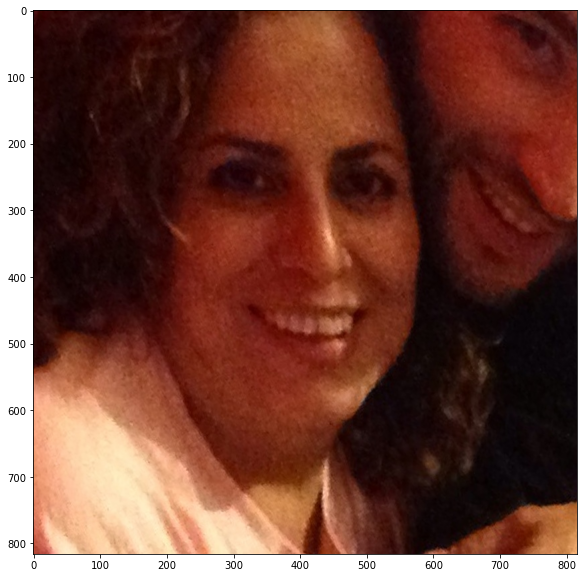

In [4]:
im = cv2.imread(str(ROOT.joinpath(list(labels)[500])))[..., ::-1]
#im = cv2.imread(str(labels.json[500]))[..., ::-1]
show_img(im)

In [5]:
# define train transforms and valid transforms

# height, width
image_size = (224, 224)

augmentations = [
    albu.RandomResizedCrop(*image_size, scale=(0.6, 1)),
    albu.HorizontalFlip(),
    albu.RandomBrightnessContrast(),
    albu.OneOf([
        albu.CLAHE(),
        albu.Blur(5),
        albu.RGBShift()  
    ], p=1),
]

# for debugging purposes only
show_transforms = albu.Compose(augmentations)

train_transforms = albu.Compose([
    *augmentations,
    albu.Normalize(),
    ToTensorV2()
])

valid_transforms = albu.Compose([
    albu.Resize(*(np.array(image_size) * 1.25).astype(int)),
    albu.CenterCrop(*image_size),
    albu.Normalize(),
    ToTensorV2()
])


test_transforms=valid_transforms

In [6]:
%%timeit
transformed = show_transforms(image=im)['image']

2.62 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


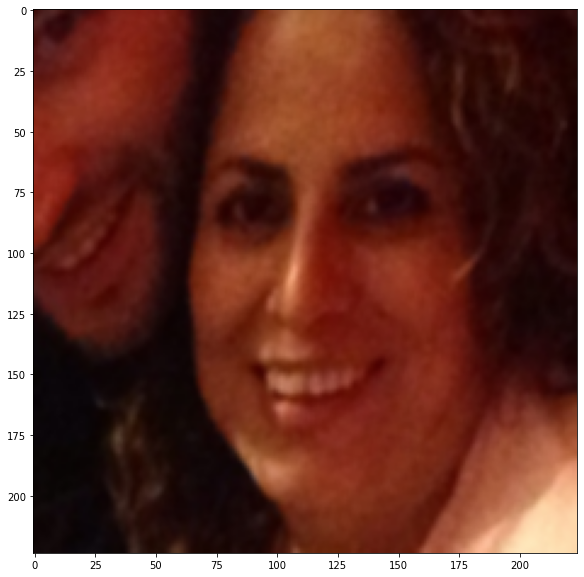

In [7]:
show_img(show_transforms(image=im)['image'])

In [8]:
class AgeGenderDataset(Dataset):
    """Very simple dataset for age&gender task"""
    def __init__(self, root, items, transform):
        self.root = root
        self.items = items
        self.transform = transform
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        filepath, meta = self.items[idx]
        img = cv2.imread(str(self.root.joinpath(filepath)))[..., ::-1]
        img = self.transform(image=img)['image']
        #age_id, gender_id = torch.tensor(meta['age_id']), torch.tensor(meta['gender_id'])
        age_id = torch.tensor(meta['age_id'])
        #return img, (age_id, gender_id)
        return img, (age_id)


In [9]:
batch_size=16
#根据Folds将数据集划分五折交叉所需的训练集、验证集、测试集
items = np.array(list(labels.items()))

#划分测试集
test_loader=[]
test_idx=[]
for k in range(5):
    temp_idx=[]
    for line in open('./Folds/Folds/train_val_txt_files_per_fold/test_fold_is_'+str(k)+'/age_test.txt', "r"):
        line=line.strip("\n")
        line,l=line.split()
        x=np.argwhere(items==line)
        if len(x)!=0:
            temp_idx.append(x[0][0])
    test_idx.append(temp_idx)
    temp_idx=np.array(temp_idx)
    test_loader.append( DataLoader(
        AgeGenderDataset(ROOT, items[temp_idx], test_transforms),
        batch_size,
        shuffle=False,
        num_workers=0
    ))

#划分验证集
valid_loader=[]
valid_idx=[]
for k in range(5):
    temp_idx=[]
    for line in open('./Folds/Folds/train_val_txt_files_per_fold/test_fold_is_'+str(k)+'/age_val.txt', "r"):
        line=line.strip("\n")
        line,l=line.split()
        x=np.argwhere(items==line)
        if len(x)!=0:
            temp_idx.append(x[0][0])
    valid_idx.append(temp_idx)
    temp_idx=np.array(temp_idx)
    valid_loader.append( DataLoader(
        AgeGenderDataset(ROOT, items[temp_idx], valid_transforms),
        batch_size,
        shuffle=False,
        num_workers=0
    ))

#划分训练集
train_loader=[]
train_idx=[]
for k in range(5):
    temp_idx=[]
    for line in open('./Folds/Folds/train_val_txt_files_per_fold/test_fold_is_'+str(k)+'/age_train.txt', "r"):
        line=line.strip("\n")
        line,l=line.split()
        x=np.argwhere(items==line)
        if len(x)!=0:
            temp_idx.append(x[0][0])
    train_idx.append(temp_idx)
    temp_idx=np.array(temp_idx)
    train_loader.append( DataLoader(
        AgeGenderDataset(ROOT, items[temp_idx], train_transforms),
        batch_size,
        shuffle=True,
        num_workers=0
    ))


In [10]:
#检查训练集测试集是否重合
for k in range(5):
    if len(np.intersect1d(test_idx[k],train_idx[k]))==0:
        print(f"Fold {k}: no intersection")

Fold 0: no intersection
Fold 1: no intersection
Fold 2: no intersection
Fold 3: no intersection
Fold 4: no intersection


In [11]:
len(train_loader)

5

In [13]:
# VALID_AMOUNT = 0.1
# batch_size = 16
# # labels for data
# items = np.array(list(labels.items()))
# valid_idx = np.random.randint(len(items), size=int(VALID_AMOUNT * len(items)))
# train_idx = np.array([i for i in np.arange(len(items)) if not (i == valid_idx).any()])

# train_loader = DataLoader(
#     AgeGenderDataset(ROOT, items[train_idx], train_transforms),
#     batch_size,
#     shuffle=True,
#     num_workers=0
# )

# valid_loader = DataLoader(
#     AgeGenderDataset(ROOT, items[valid_idx], valid_transforms),
#     batch_size,
#     shuffle=False,
#     num_workers=0
# )

In [12]:
def accuracy(pred: torch.Tensor, gt: torch.Tensor):###################################################3
    """
    accuracy metric
    
    expects pred shape bs x n_c, gt shape bs x 1
    """
    return (pred.max(1)[1] == gt).float().mean()

In [13]:
#训练前查看cuda是否可用
import torch
print(torch.cuda.is_available())


True


In [14]:
!pip install timm
import timm
mobilenet_v3 = timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
mobilenet_v3_encoder = nn.Sequential(*list(mobilenet_v3.children())[:-4]).cuda()

In [15]:
class AgeGenderModel(nn.Module):
    """
    CNN model with 2 heads and SE-block
    with multitask model learns faster
    """
    def __init__(self, encoder, encoder_channels, 
                 age_classes, output_channels=512):
        super().__init__()
        
        # encoder features (resnet50 in my case)
        # output should be bs x c x h x w
        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        #self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        #gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits

In [16]:
#model = AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8, gender_classes=3).cuda()
model=[]
for k in range(5):
    model.append(AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8).cuda())


In [17]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model[0].parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
#gender_criterion = nn.CrossEntropyLoss()

In [18]:
def train(model, loader, opt, 
          age_criterion, metric_fn, 
          device="cuda", sched=None, epoch=1, print_every=50):
    model.train()
    t0 = time.time()
    for batch_idx, (image, age_gt) in enumerate(loader):
        data_time = time.time() - t0
        #print(1)
        opt.zero_grad()
        #print(2)
        t1 = time.time()
        image, age_gt = image.to(device), age_gt.to(device)
        age_logits = model(image)
        
        # BCE expects one-hot vector
        age_gt_onehot = torch.zeros(*age_logits.size(), device=age_logits.device)
        age_gt_onehot = age_gt_onehot.scatter_(1, age_gt.unsqueeze(-1).long(), 1)
        #gender_gt = gender_gt.long()
        
        model_time = time.time() - t1
        loss_age = age_criterion(age_logits, age_gt_onehot)  # bce
        #loss_gender = gender_criterion(gender_logits, gender_gt)  # softmax+ce
        loss = loss_age
        loss.backward()
        opt.step()
        if sched is not None:
            sched.step()
        #gender_acc = metric_fn(gender_logits, gender_gt)
        age_acc = metric_fn(age_logits, age_gt)
        
        if batch_idx % print_every == 0:
            print(f"train epoch {epoch}, {batch_idx} / {len(loader)}, loss age {loss_age.item():.3f} "
                  f"age acc: {age_acc.item():.2%} "
                  f"data/model times {data_time*1000:.1f} ms, {model_time*1000:.1f} ms")
        t0 = time.time()
        

def validate(model, loader, metric_fn, device="cuda", epoch=1):
    model.eval()
    #gender_acc_list = []
    age_acc_list = []
    for image, age_gt in loader:
        with torch.no_grad():
            image, age_gt = image.to(device), age_gt.to(device)
            age_logits = model(image)
            #gender_acc_list.append(metric_fn(gender_logits, gender_gt).item())
            age_acc_list.append(metric_fn(age_logits, age_gt).item())
    #gender_acc = np.mean(gender_acc_list)
    age_acc = np.mean(age_acc_list)
    print(f"val age acc {age_acc:.2%}")
    return age_acc / 2


def test(model, loader, metric_fn, device="cuda"):
    model.eval()
    age_acc_list = []
    for image, age_gt in loader:
        with torch.no_grad():
            image, age_gt = image.to(device), age_gt.to(device)
            age_logits = model(image)
            age_acc_list.append(metric_fn(age_logits, age_gt).item())
    age_acc = np.mean(age_acc_list)
    print(f"test age acc {age_acc:.2%}")
    return age_acc 



In [25]:
time_lst=[]
acc=[]
import time
for k in range(0,1):
    print(f"Fold {k} begins to train:")
    t1=time.time()
    for epoch in range(1, num_epochs+1):
        train(model[k], train_loader[k], optimizer, 
            age_criterion, metric_fn=accuracy, 
            device="cuda", epoch=epoch, print_every=100)
        val_acc = validate(model[k], valid_loader[k], metric_fn=accuracy, device="cuda", epoch=epoch)
        scheduler.step(val_acc)
    test_acc=test(model[k],test_loader[k],metric_fn=accuracy, device="cuda")
    acc.append(test_acc)
    t2=time.time()-t1
    time_lst.append(t2)
    print(f"Fold {k} test_acc :{test_acc:.2%},time :{t2:.2f}. ")
    #保存模型
    torch.save(model[k].state_dict(), './model/mobilenetv3_age_Fold_'+str(k)+'.pth')
    print()

Fold 0 begins to train:
train epoch 1, 0 / 736, loss age 0.681 age acc: 12.50% data/model times 153.9 ms, 20.2 ms
train epoch 1, 100 / 736, loss age 0.573 age acc: 81.25% data/model times 152.5 ms, 12.5 ms
train epoch 1, 200 / 736, loss age 0.496 age acc: 81.25% data/model times 159.5 ms, 17.8 ms
train epoch 1, 300 / 736, loss age 0.478 age acc: 81.25% data/model times 188.5 ms, 17.1 ms
train epoch 1, 400 / 736, loss age 0.496 age acc: 50.00% data/model times 160.9 ms, 14.5 ms
train epoch 1, 500 / 736, loss age 0.371 age acc: 87.50% data/model times 172.7 ms, 13.7 ms
train epoch 1, 600 / 736, loss age 0.403 age acc: 68.75% data/model times 167.0 ms, 14.6 ms
train epoch 1, 700 / 736, loss age 0.354 age acc: 81.25% data/model times 179.2 ms, 15.7 ms
val age acc 83.25%
train epoch 2, 0 / 736, loss age 0.326 age acc: 93.75% data/model times 161.2 ms, 17.9 ms
train epoch 2, 100 / 736, loss age 0.364 age acc: 81.25% data/model times 172.1 ms, 12.8 ms
train epoch 2, 200 / 736, loss age 0.320 

In [27]:
torch.save(model[k].state_dict(), './model/mobilenetv3_age_Fold_'+str(k)+'.pth')

In [29]:
#test acc mean and time
macc=0
for k in range(5):
    macc+=acc[k]
    print(f"Fold {k} test_acc :{acc[k]:.2%}. ")
print(f"Mean accuracy is {macc/5:.2%}.")


Fold 0 test_acc :89.34%. 
Fold 1 test_acc :93.17%. 
Fold 2 test_acc :95.89%. 
Fold 3 test_acc :88.28%. 
Fold 4 test_acc :54.75%. 
Mean accuracy is 84.29%.


In [42]:
#torch.save(model.state_dict(), "/content/mobilenetv3_age.pth")

In [114]:
!pip install thop

In [30]:
#显示评估指标
#Paramater Size and FLOPS#显示参数量
from thop import profile
device="cuda"
input = torch.randn(1, 3, 32, 32)
input = input.to(device)
flops, params = profile(model[0], inputs=(input,))
print(flops)
print(params)

[WARN] Cannot find rule for <class 'timm.models.layers.conv2d_same.Conv2dSame'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.linear.Identity'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Hardswish'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'timm.models.layers.norm_act.BatchNormAct2d'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'timm.models.efficientnet_blocks.DepthwiseSeparableConv'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'timm.models.efficientnet_blocks.InvertedResidual'>. Treat it as zero Macs and zero Params.
[WARN]

c:\ProgramData\Anaconda3\envs\pytorch_gpu\lib\site-packages\thop\vision\basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()
